In [93]:
using LinearAlgebra
using Plots
using CSV, DataFrames
using LaTeXStrings

In [94]:
function shift_rotate(x, y, θ, x_shift, y_shift, θ_shift)
    v = [x - x_shift, y-y_shift]
    R = [cos(θ_shift) sin(θ_shift); -sin(θ_shift) cos(θ_shift)]
    vf = R*v
    return vf[1], vf[2], (θ - θ_shift)
end

shift_rotate (generic function with 1 method)

In [95]:
# This is the actual data-set
dubinsData = CSV.read("./DataFiles/twoCarsData.csv", DataFrame)

# Add mirrored data so that more data is available
dataMirrored = dubinsData

dataMirrored.yP = -dataMirrored.yP    # y = -y
dataMirrored.thetaP = -dataMirrored.thetaP    # th = -th
dataMirrored.inputP = -dataMirrored.inputP    # u = -u

dataMirrored.yE = -dataMirrored.yE    # y = -y
dataMirrored.thetaE = -dataMirrored.thetaE    # th = -th
dataMirrored.inputE = -dataMirrored.inputE    # u = -u

dubinsData = append!(dubinsData,dataMirrored)

dataP = dubinsData[:, [:xP, :yP, :thetaP, :xE, :yE, :thetaE, :inputP]]
dataE = dubinsData[:, [:xP, :yP, :thetaP, :xE, :yE, :thetaE, :inputE]]
dataP.inputP = Int.(round.(dataP.inputP))
dataE.inputE = Int.(round.(dataE.inputE))

# Transform dataP to pursuer's frame of reference
N = length(dataP.inputP)
for i=1:N
    dataP.xE[i], dataP.yE[i], dataP.thetaE[i] = shift_rotate(dataP.xE[i], dataP.yE[i], dataP.thetaE[i], dataP.xP[i], dataP.yP[i], dataP.thetaP[i])
    dataP.xP[i] = 0
    dataP.yP[i] = 0
    dataP.thetaP[i] = 0
end

# Transform dataE to evader's frame of reference
for i=1:N
    dataE.xP[i], dataE.yP[i], dataE.thetaP[i] = shift_rotate(dataE.xP[i], dataE.yP[i], dataE.thetaP[i], dataE.xE[i], dataE.yE[i], dataE.thetaE[i])
    dataE.xE[i] = 0
    dataE.yE[i] = 0
    dataE.thetaE[i] = 0
end

print(N)

18000

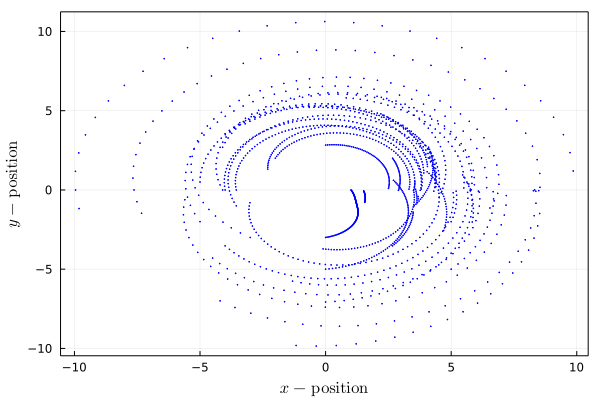

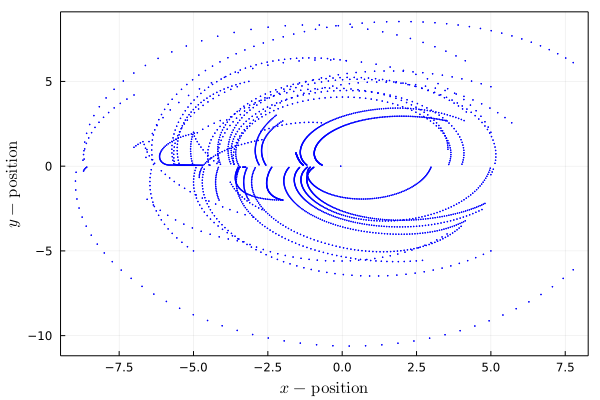

3262×4 DataFrame
  Row │ xE            yE            thetaE        inputP 
      │ Float64       Float64       Float64       Int64  
──────┼──────────────────────────────────────────────────
    1 │  5.0          -5.0          -1.5708           -1
    2 │  5.27298      -4.67222      -1.46492          -1
    3 │  5.52584      -4.32546      -1.35904          -1
    4 │  5.75721      -3.96081      -1.25317          -1
    5 │  5.96576      -3.57946      -1.14729          -1
    6 │  6.15021      -3.18269      -1.04142          -1
    7 │  6.30934      -2.77192      -0.935543         -1
    8 │  6.442        -2.34864      -0.829674         -1
    9 │  6.54711      -1.91448      -0.72381          -1
   10 │  6.62367      -1.47117      -0.617957         -1
   11 │  6.67078      -1.02062      -0.512128         -1
   12 │  6.68767      -0.565083     -0.406378         -1
   13 │  6.67372      -0.10959      -0.30116          -1
   14 │ -4.2          -7.0          -1.5708           -1
   15 │ -3.

In [96]:
# Remove straight line data-points in dataP
cond1 = (dataP.yE .<= -0.055) .| (dataP.yE .>= 0.055)  # Keep this data which is away from x-axis
cond2 = (collect(1:length(dataP.yE))) .% 1 .== 0  # Keep this data which is index less than 2000
cond3 = (dataP.inputP .!= 0) # Keep the data only if input is nonzero
dataP = dataP[(cond1 .| cond2) .& cond3,:]
select!(dataP, [:xE, :yE, :thetaE ,:inputP])
figDataP = scatter(dataP.xE, dataP.yE, markersize = 1, 
                   color = :blue, msc=:blue, markershape = :circle,
		           legend = false, frame_style = :box)
xlabel!(figDataP, L"$x-\textrm{position}$")
ylabel!(figDataP, L"$y-\textrm{position}$")

# Remove straight line data-points in dataE
cond1 = (dataE.yP .<= -0.055) .| (dataE.yP .>= 0.055)  # Keep this data which is away from x-axi
cond2 = (collect(1:length(dataE.yP))) .% 2000 .== 0  # Keep this data which is index less than 2000
cond3 = (dataE.inputE .!= 0) # Keep the data only if input is nonzero
dataE = dataE[(cond1 .| cond2) .& cond3,:]
select!(dataE, [:xP, :yP, :thetaP ,:inputE])
figDataE = scatter(dataE.xP, dataE.yP, markersize = 1, 
                   color = :blue, msc=:blue, markershape = :circle,
		           legend = false, frame_style = :box)
xlabel!(figDataE, L"$x-\textrm{position}$")
ylabel!(figDataE, L"$y-\textrm{position}$")

display(figDataP)
display(figDataE)
print(dataP)

In [97]:
using ScikitLearn
using ScikitLearn.CrossValidation: train_test_split
@sk_import tree: DecisionTreeClassifier
@sk_import preprocessing: StandardScaler
@sk_import ensemble: RandomForestClassifier
@sk_import tree: export_graphviz
@sk_import metrics: accuracy_score

PyObject <function accuracy_score at 0x000000009C901820>

## Pursuer Training

In [98]:
X_p = [dataP.xE dataP.yE dataP.thetaE]
y_p = dataP.inputP

# Split the data into test-train set
X_train, X_test, y_train, y_test = train_test_split(X_p, y_p, test_size = 0.20)

# naming the classifier Pursuer
Pursuer = RandomForestClassifier(n_estimators = 100)
Pursuer.fit(X_train, y_train)



dot_data = export_graphviz(Pursuer.estimators_[99], 
                           #feature_names=wine.feature_names,
                           #class_names=wine.target_names, 
                           filled=true, impurity=true, 
                           rounded=true)
# println(dot_data)

y_pred = Pursuer.predict(X_test)

println("ACCURACY OF THE MODEL: ", accuracy_score(y_test, y_pred))

ACCURACY OF THE MODEL: 0.996937212863706


## Evader Training

In [99]:
X_e = [dataE.xP dataE.yP dataE.thetaP]
y_e = dataE.inputE

# Split the data into test-train set
X_train, X_test, y_train, y_test = train_test_split(X_e, y_e, test_size = 0.20)

# naming the classifier Pursuer
Evader = RandomForestClassifier(n_estimators = 100)
Evader.fit(X_train, y_train)



dot_data = export_graphviz(Evader.estimators_[99], 
                           #feature_names=wine.feature_names,
                           #class_names=wine.target_names, 
                           filled=true, impurity=true, 
                           rounded=true)
# println(dot_data)

y_pred = Evader.predict(X_test)

println("ACCURACY OF THE MODEL: ", accuracy_score(y_test, y_pred))

ACCURACY OF THE MODEL: 1.0


In [100]:
## Simulation of pursuit-evasion game

In [105]:
# Simulation using the learned model
dubins_dynP(x, u) = [2*cos(x[3]), 2*sin(x[3]), 2*u]
dubins_dynE(x, u) = [1.0*cos(x[3]), 1.0*sin(x[3]), 1.0*u]


stateP0 = [0, 0, 0]
stateE0 = [0, 7, -π/2]
n_iter = 1500
dt = 0.01

statesP = zeros(n_iter, 3)
inputP = zeros(n_iter)
statesE = zeros(n_iter, 3)
inputE = zeros(n_iter)

statesP[1,:] .= stateP0
statesE[1,:] .= stateE0
last_ind = 1

for i=1:n_iter-1
    sP = statesP[i, :]
    sE = statesE[i, :]

    sET = shift_rotate(sE[1], sE[2], sE[3], sP[1], sP[2], sP[3])
    uP = Pursuer.predict([sET[1] sET[2] sET[3]])[1]
    statesP[i+1,:] .= statesP[i,:] .+ dt*dubins_dynP(statesP[i,:], uP[1])

    sPT = shift_rotate(sP[1], sP[2], sP[3], sE[1], sE[2], sE[3])
    uE = Evader.predict([sPT[1] sPT[2] sPT[3]])[1]
    statesE[i+1,:] .= statesE[i,:] .+ dt*dubins_dynE(statesE[i,:], uE[1])

    last_ind = i
    if norm(sP[1:2] - sE[1:2]) < 0.1
        println("Captured!!")
        break
    end
end



Captured!!


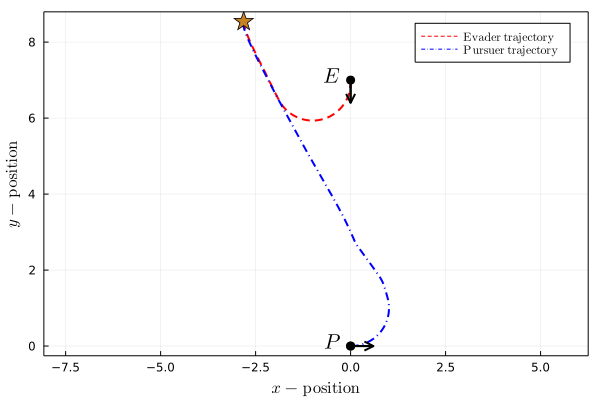

In [112]:
# fig1 = plot(statesP[1:last_ind,1], statesP[1:last_ind,2], aspect_ratio = 1,
# 			frame_style = :box)
# plot!(fig1,statesE[1:last_ind,1], statesE[1:last_ind,2], aspect_ratio = 1)
# xlabel!(fig1, L"$x-\textrm{position}$")
# ylabel!(fig1, L"$y-\textrm{position}$")
# scatter!(fig1,[],[])
# print(last_ind)
# display(fig1)
#Plotting both of them together
fig1 = plot(aspect_ratio=1, frame_style=:box, lw=2)
plot!(fig1, statesE[1:last_ind,1], statesE[1:last_ind,2], color=:red, ls=:dash, lw=2, label=L"$\textrm{Evader \; trajectory}$")
plot!(fig1, statesP[1:last_ind,1], statesP[1:last_ind,2], color=:blue, ls=:dashdot, lw=2, label=L"$\textrm{Pursuer \; trajectory}$")
# label(fig1, ["Evader trajectory", "Pursuer trajectory"])
# scatter!(fig1, [statesE[last_ind,1]], [statesE[last_ind,2]], label=nothing)
# scatter!(fig1, [statesP[last_ind,1]], [statesP[last_ind,2]], label=nothing)
# scatter!(fig1, [xf[1], x0[1]], [xf[2], x0[2]], ms = 7)
xlabel!(fig1, L"$x-\textrm{position}$")
ylabel!(fig1, L"$y-\textrm{position}$")
x_p0, y_p0 = statesP[1,1], statesP[1,2]
x_e0, y_e0 = statesE[1,1], statesE[1,2]
plot!(fig1, [x_p0, x_p0 + 0.6], [y_p0, y_p0], color=:black, arrow=true, arrowsize=1, lw=2, label=nothing)
scatter!(fig1, [x_p0], [y_p0], color=:black, markersize=5, label=nothing)
plot!(fig1, [x_e0, x_e0], [y_e0, y_e0 - 0.6], color=:black, arrow=true, arrowsize=1, lw=2, label=nothing)
scatter!(fig1, [x_e0], [y_e0], color=:black, markersize=5, label=nothing)
# plot!(fig1, [0.0, 0.4], [0.0, 0.0], color=:black, arrow=true, arrowsize=1, lw=2, label=nothing)
scatter!(fig1, [0], [0], color=:black, markersize=5, label=nothing)
scatter!(fig1, [statesE[last_ind,1]], [statesE[last_ind,2]], shape=:star5, label=nothing, markersize=10)
annotate!(fig1, x_p0 - 0.5, y_p0 + 0.2, L"$\bf{P}$")
annotate!(fig1, x_e0 - 0.5, y_e0 + 0.2, L"$\bf{E}$")
# x_f = xf[1]
# y_f = xf[2]
# annotate!(fig1, xf[1] + 1.0, xf[2] + 0.3, L"$x_f = [%$x_f, %$y_f]$")
display(fig1)